In [ ]:
"""
Frequency domain patch-based denoising
"""
import numpy as np
import cv2
from scipy.fftpack import dct, idct

def dct_denoise_image(image, patch_size=8, keep_fraction=0.9):
    """Denoise image via DCT thresholding with proper edge handling."""
    # Pad image to handle edges (mirror padding reduces boundary artifacts)
    pad_y = patch_size - image.shape[0] % patch_size
    pad_x = patch_size - image.shape[1] % patch_size
    image_padded = np.pad(image, ((0, pad_y), (0, pad_x)), mode='reflect')
    
    # Initialize output and weight matrices
    denoised = np.zeros_like(image_padded, dtype=float)
    weights = np.zeros_like(image_padded, dtype=float)
    
    # Process patches with 50% overlap
    stride = patch_size // 2
    for y in range(0, image_padded.shape[0] - patch_size + 1, stride):
        for x in range(0, image_padded.shape[1] - patch_size + 1, stride):
            # Extract patch
            patch = image_padded[y:y+patch_size, x:x+patch_size]
            # DCT + thresholding
            dct_patch = dct(dct(patch.T, norm='ortho').T, norm='ortho')
            coeffs = np.sort(np.abs(dct_patch.ravel()))[::-1]
            threshold = coeffs[int(len(coeffs) * keep_fraction)]
            dct_patch[np.abs(dct_patch) < threshold] = 0
            
            # Inverse DCT and accumulate
            denoised_patch = idct(idct(dct_patch.T, norm='ortho').T, norm='ortho')
            denoised[y:y+patch_size, x:x+patch_size] += denoised_patch
            weights[y:y+patch_size, x:x+patch_size] += 1
    
    # Normalize by weight counts and crop to original size
    denoised = denoised / weights
    return image_padded,denoised[:image.shape[0], :image.shape[1]]

In [ ]:
path_in = './test_images/cameraman.png'
img = cv2.imread(path_in,0)
sigma=30
noisy_image = img + sigma * np.random.random(img.shape)

PSNR FreqPatch: 23.35 dB
PSNR Noisy: 23.37 dB


Text(0.5, 0, 'PSNR=23.37 DB')

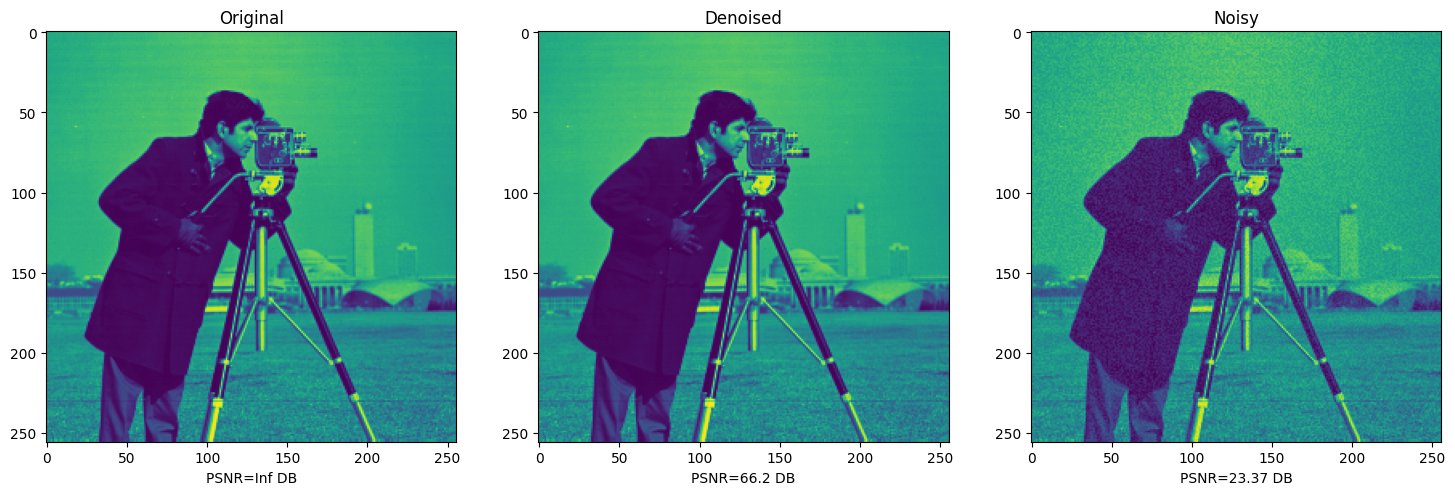

In [ ]:
# Example usage:
image_padded,denoised=dct_denoise_image(img)
import matplotlib.pyplot as plt
fig,axs=plt.subplots(1,3,figsize=(18,6))
psnr_denoised = 10*np.log10(255**2 / np.mean((denoised - img)**2))
print("PSNR FreqPatch:", round(float(psnr), 2), "dB")
psnr = 10*np.log10(255**2 / np.mean((noisy_image - img)**2))
print("PSNR Noisy:", round(float(psnr), 2), "dB")
axs[0].imshow(img)
axs[0].set_title("Original")
axs[0].set_xlabel("PSNR=Inf DB")
axs[1].imshow(denoised)
axs[1].set_title("Denoised")
axs[1].set_xlabel(f"PSNR={np.round(psnr_denoised,2)} DB")
axs[2].imshow(noisy_image)
axs[2].set_title("Noisy")
axs[2].set_xlabel(f"PSNR={np.round(psnr,2)} DB")